In [4]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [10]:
# Load the data
df = pd.read_csv('C:/Users/a0095989/Desktop/important/Thesis/Model_Thesis/imputed_deu_data1.csv')

# Convert Year/Month into a datetime format for each city
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(day=1))

# Prepare data for splitting by city
train, validate, test = {}, {}, {}

# Loop through each city and split the data
for city in df['City'].unique():
    print(f"Splitting data for {city}...")
    
    # Filter data for the city
    df_city = df[df['City'] == city].copy()
    df_city.set_index('Date', inplace=True)
    df_city.sort_index(inplace=True)

    # Split data into training, validation, and testing sets
    train[city] = df_city[df_city['Year'] <= 2010]  # Training data up to 2010
    validate[city] = df_city[(df_city['Year'] > 2010) & (df_city['Year'] <= 2012)]  # Validation data (2011-2012)
    test[city] = df_city[(df_city['Year'] == 2013) & (df_city['Month'] <= 9)]  # Test data (2013, first 9 months)
    
    # You can also print some data samples to verify
    #print(f"Training set size: {train[city].shape}")
    #print(f"Validation set size: {validate[city].shape}")
    #print(f"Testing set size: {test[city].shape}")


Splitting data for Aachen...
Splitting data for Augsburg...
Splitting data for Bergisch Gladbach...
Splitting data for Berlin...
Splitting data for Bielefeld...
Splitting data for Bochum...
Splitting data for Bonn...
Splitting data for Bottrop...
Splitting data for Bremen...
Splitting data for Bremerhaven...
Splitting data for Brunswick...
Splitting data for Chemnitz...
Splitting data for Cologne...
Splitting data for Cottbus...
Splitting data for Düsseldorf...
Splitting data for Darmstadt...
Splitting data for Dortmund...
Splitting data for Dresden...
Splitting data for Duisburg...
Splitting data for Erfurt...
Splitting data for Erlangen...
Splitting data for Essen...
Splitting data for Fürth...
Splitting data for Frankfurt...
Splitting data for Freiburg...
Splitting data for Göttingen...
Splitting data for Gelsenkirchen...
Splitting data for Gera...
Splitting data for Hagen...
Splitting data for Halle...
Splitting data for Hamburg...
Splitting data for Hamm...
Splitting data for Hano

In [6]:
# Prepare storage for forecasts
forecasts = {}

# Loop through each city and train the XGBoost model
for city in train.keys():
    print(f"Training XGBoost for {city}...")
    
    # Get the training data for the city
    df_city_train = train[city]
    
    # Drop non-numeric columns (City, Latitude, Longitude, Season) or apply one-hot encoding
    df_city_train = df_city_train.drop(columns=['City', 'Latitude', 'Longitude'])  # Drop non-numeric columns
    df_city_train = pd.get_dummies(df_city_train, columns=['Season'], drop_first=True)  # Optional: Encode 'Season'
    
    X_train = df_city_train.drop(columns=['AverageTemperature'])
    y_train = df_city_train['AverageTemperature']
    
    # Train XGBoost model
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
    xgb_model.fit(X_train, y_train)

    # Get the test data for the city
    df_city_test = test[city]
    
    # Apply the same transformations to the test set
    df_city_test = df_city_test.drop(columns=['City', 'Latitude', 'Longitude'])  # Drop non-numeric columns
    df_city_test = pd.get_dummies(df_city_test, columns=['Season'], drop_first=True)  # Optional: Encode 'Season'
    
    X_test = df_city_test.drop(columns=['AverageTemperature'])
    y_test = df_city_test['AverageTemperature']
    
    # Forecast for the test set
    forecast_values = xgb_model.predict(X_test)
    
    # Store forecasted values
    forecasts[city] = forecast_values


Training XGBoost for Aachen...
Training XGBoost for Augsburg...
Training XGBoost for Bergisch Gladbach...
Training XGBoost for Berlin...
Training XGBoost for Bielefeld...
Training XGBoost for Bochum...
Training XGBoost for Bonn...
Training XGBoost for Bottrop...
Training XGBoost for Bremen...
Training XGBoost for Bremerhaven...
Training XGBoost for Brunswick...
Training XGBoost for Chemnitz...
Training XGBoost for Cologne...
Training XGBoost for Cottbus...
Training XGBoost for Düsseldorf...
Training XGBoost for Darmstadt...
Training XGBoost for Dortmund...
Training XGBoost for Dresden...
Training XGBoost for Duisburg...
Training XGBoost for Erfurt...
Training XGBoost for Erlangen...
Training XGBoost for Essen...
Training XGBoost for Fürth...
Training XGBoost for Frankfurt...
Training XGBoost for Freiburg...
Training XGBoost for Göttingen...
Training XGBoost for Gelsenkirchen...
Training XGBoost for Gera...
Training XGBoost for Hagen...
Training XGBoost for Halle...
Training XGBoost for

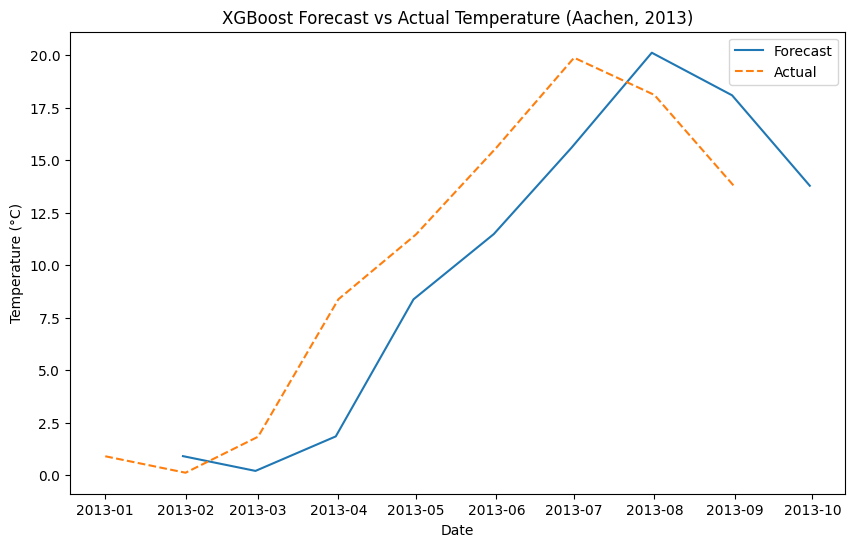

In [7]:
# Plot the forecasted values for a sample city (e.g., "Aachen")
plt.figure(figsize=(10, 6))
plt.plot(forecast_df.index, forecast_df['Aachen'], label="Forecast")
plt.plot(df_city_test.index, df_city_test['AverageTemperature'], label="Actual", linestyle='--')
plt.title("XGBoost Forecast vs Actual Temperature (Aachen, 2013)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()


In [8]:
from sklearn.metrics import mean_absolute_error, r2_score

# Prepare storage for evaluation metrics
mae_scores = {}
r2_scores = {}

# Prepare storage for actual and predicted values (for overall R² calculation)
all_actual = []
all_predicted = []

# Loop through each city for evaluation metrics
for city in train.keys():
    print(f"Evaluating XGBoost for {city}...")
    
    # Get the test data for the city
    df_city_test = test[city]
    
    X_test = df_city_test.drop(columns=['City', 'Latitude', 'Longitude', 'AverageTemperature'])
    y_test = df_city_test['AverageTemperature']
    
    forecast_values = forecasts[city]
    
    # Calculate MAE and R² for the city
    mae = mean_absolute_error(y_test, forecast_values)
    r2 = r2_score(y_test, forecast_values)
    
    mae_scores[city] = mae
    r2_scores[city] = r2
    
    # Append actual and predicted values for overall R²
    all_actual.extend(y_test)
    all_predicted.extend(forecast_values)

# Calculate overall R² score for all cities
overall_r2 = r2_score(all_actual, all_predicted)

# Print MAE and R² scores for all cities
mae_df = pd.DataFrame(mae_scores, index=['MAE'])
r2_df = pd.DataFrame(r2_scores, index=['R²'])

print(mae_df)
print(r2_df)

# Print overall R² score for all cities
print(f"Overall Coefficient of Determination (R²) for all cities: {overall_r2}")


Evaluating XGBoost for Aachen...
Evaluating XGBoost for Augsburg...
Evaluating XGBoost for Bergisch Gladbach...
Evaluating XGBoost for Berlin...
Evaluating XGBoost for Bielefeld...
Evaluating XGBoost for Bochum...
Evaluating XGBoost for Bonn...
Evaluating XGBoost for Bottrop...
Evaluating XGBoost for Bremen...
Evaluating XGBoost for Bremerhaven...
Evaluating XGBoost for Brunswick...
Evaluating XGBoost for Chemnitz...
Evaluating XGBoost for Cologne...
Evaluating XGBoost for Cottbus...
Evaluating XGBoost for Düsseldorf...
Evaluating XGBoost for Darmstadt...
Evaluating XGBoost for Dortmund...
Evaluating XGBoost for Dresden...
Evaluating XGBoost for Duisburg...
Evaluating XGBoost for Erfurt...
Evaluating XGBoost for Erlangen...
Evaluating XGBoost for Essen...
Evaluating XGBoost for Fürth...
Evaluating XGBoost for Frankfurt...
Evaluating XGBoost for Freiburg...
Evaluating XGBoost for Göttingen...
Evaluating XGBoost for Gelsenkirchen...
Evaluating XGBoost for Gera...
Evaluating XGBoost for H